In [14]:
import os
import segmentation_models_pytorch as smp

from scripts.plotting import show_images
from scripts.preprocessing import RoadDataset, split_data
from torch.utils.data import DataLoader

In [2]:
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'training')
image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.2)

In [3]:
# Get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train)
valid_dataset = RoadDataset(image_path_test, mask_path_test)

n_cpu = os.cpu_count()

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=n_cpu)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=n_cpu)

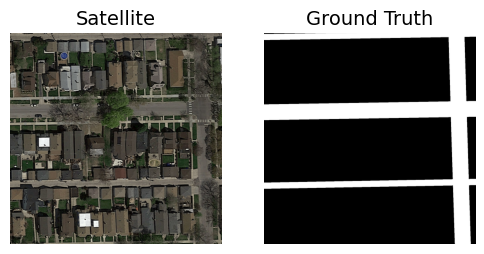

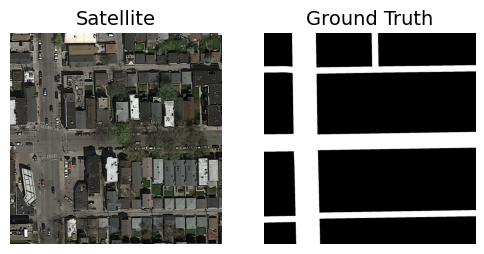

In [4]:
for i in range(2):
    img, mask = train_dataset.images[i], train_dataset.masks[i]
    show_images(axis=False, satellite=img, ground_truth=mask)

In [16]:
from scripts.modelling import RoadModel

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'road']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

model = RoadModel("FPN", ENCODER, in_channels=3, out_classes=1)

In [ ]:
import pytorch_lightning as pl

trainer = pl.Trainer(
    max_epochs=1,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)
     

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 26.1 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.464   Total estimated model params size (MB)
